After loading the dataset, this analysis is mainly divided into five parts:

1. Quick EDA: check data shape, view null, check labels
2. Data preparation: normalization, reshape, one-hot label representation, train-test split
3. CNN: define model, optimizer, dynamic learning rate, data augmentation
4. Evaluate model: model accuracy, loss, confusion matrix and error analysis
5. Prediction and submission: apply model on test dataset

At the end, I have compared different optimizers for classification to justify my selection of classifier.

# 0. Load libraries and dataet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1. EDA

Below are some quick exploration of the dataset.

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have 784 pixel (28 x 28) columns and 1 label column in training dataset.

In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Test dataset does not have label column because we are going to predict it.

Let us see the labels in the train dataset.

In [5]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

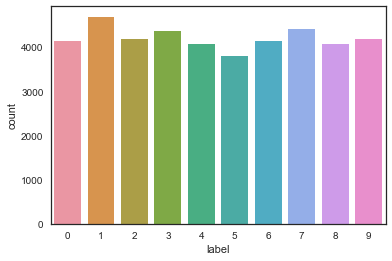

In [6]:
g = sns.countplot(Y_train)

Train dataset has 10 labels (digits from 0 to 9) and ther distribution are very similar.  
Below are actual counts on each label.

In [7]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

### Check for null and missing values

In [8]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing values an we can safely proceed without data imputation or exclusion.

# 2. Data preparation

### Normalization

We perform greyscale normalization to reduce the effect of illumination differences.  
Moreover the CNN converg faster on [0..1] data than on [0..255].

In [10]:
X_train = X_train / 255.0
test = test / 255.0

### Reshape

In [11]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , chanal = 1)
X_train = X_train.values.reshape(-1,28,28,1)  # -1 suggests it is not defined and numpy will figure out
test = test.values.reshape(-1,28,28,1)

Train and test images (28 x 28) have been stock into pandas Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.  

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

### Label encoding: one-hot represenation of labels

In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to **one hot vectors** (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

### Split train and validation sets

In [13]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

A small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.  We have 42000 training images of 10 balanced labels. Therefore, a random split of the train set doesn't cause some labels to be over represented in the validation set (may not be true for unbalanced data). 

In [14]:
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(Y_train))
print(np.shape(Y_val))

(37800, 28, 28, 1)
(4200, 28, 28, 1)
(37800, 10)
(4200, 10)


### Some examples

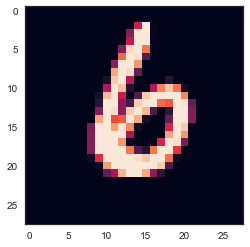

In [15]:
plt.imshow(X_train[200][:,:,0])

# 3. CNN

#### Define CNN model

###### Conv2D->relu -> Conv2D->relu  -> MaxPool2D -> Dropout -> Conv2D->relu -> Conv2D->relu  -> MaxPool2D -> Dropout -> Flatten -> Dense -> Dropout -> Dense -> Dropout -> Output

In Keras API (with Tensorflow) backend, we add one layer at a time starting from the input layer.


The **first layer is a Conv2D convolution layer** with 32 filters each with kernel size 5x5. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters identify different features in the image.  
We are using **same padding** that results in padding the input such that the output has the same length as the original input. Padding is important for the edges of the images.  
**Relu** is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.  
The **pooling (MaxPool2D)** layer acts as a downsampling filter. It looks at the 2 neighboring pixels (we are using 2x2 pull size here) and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. More the pooling dimension is high, more the downsampling is important.  
**Dropout** is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 
**The Flatten layer** is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.  
In the end I have used the features in **two fully-connected** (Dense) layers. Then I add the the last layer as the output layer  with **softmax activation** (Dense(10,activation="softmax")) that gives the probability of each 10 labels in the training data.

In [16]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

### Set the Optimizer and annealer

Since the model is set up, now we can **set up the accuracy i.e. score, loss function and Optimizer**.  
**Loss function** is the error rate between the observed labels and the predicted labels. For our multiple class classification (>2 class), we use [**categorical_crossentropy**](https://keras.io/losses/).  
The **Optimizer** minimizes loss with backpropagation. It iteratively improves the model parameters (filter kernel  values, weights and biases at each layer and each neuron). I am using [**Adam Optimization**](https://keras.io/optimizers/) that takes into account both momentum and RMSProp in gradient descent. Below are the arguments in Adam from Keras doc (I am using the default values to start with):   

lr: float >= 0. Learning rate.  
beta_1: float, 0 < beta < 1. Generally close to 1.  
beta_2: float, 0 < beta < 1. Generally close to 1.  
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().  
decay: float >= 0. Learning rate decay over each update.  
amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".  

**Accuracy** is metric function that evaluates the performance the model. Loss is expected to go lower as accuracy goes higher after each iteration (or epoch). The results from the metric evaluation are not used when training the model.  

In [17]:
# Define the optimizer
Adamopti = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [21]:
# Compile the model
model.compile(optimizer = Adamopti , loss = "categorical_crossentropy", metrics=["accuracy"])

### Learning rate and model convergence

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima. Learning rate should be sufficiently small to reach the global minimum in cost optimization however, it can be computationally costly.   
To keep the advantage of the fast computation time with a high LR, I decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).  
In ReduceLROnPlateau function from Keras.callbacks, I choose to reduce the LR by half if the accuracy is not improved after 3 epochs.  

In [19]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 1 # Turn epochs to higher number (~25 or higher) for better accuracy
batch_size = 86 # Can be other number as well

### Data Augmentation

In image data, we have the leverage to increase variation in training sample by **data augmentation that improves model accuracy**. 
This alters the training data in ways that change the array representation while keeping the label the same. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.  

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.  

* Without data augmentation, I  get validation accuracy of 97.95%.
* With data augmentation, I get validation accuracy of 98.40%

In [23]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 426s - loss: 0.3660 - acc: 0.8791 - val_loss: 0.0637 - val_acc: 0.9802


In [22]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [23]:
datagen.fit(X_train)

For the data augmentation, I choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height

I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [24]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/25
 - 423s - loss: 0.5857 - acc: 0.8062 - val_loss: 0.0828 - val_acc: 0.9762
Epoch 2/25
 - 419s - loss: 0.1742 - acc: 0.9512 - val_loss: 0.0506 - val_acc: 0.9864
Epoch 3/25
 - 417s - loss: 0.1311 - acc: 0.9644 - val_loss: 0.0676 - val_acc: 0.9793
Epoch 4/25
 - 405s - loss: 0.1064 - acc: 0.9703 - val_loss: 0.0321 - val_acc: 0.9914
Epoch 5/25
 - 384s - loss: 0.0947 - acc: 0.9738 - val_loss: 0.0379 - val_acc: 0.9879
Epoch 6/25
 - 379s - loss: 0.0811 - acc: 0.9774 - val_loss: 0.0436 - val_acc: 0.9902
Epoch 7/25
 - 380s - loss: 0.0770 - acc: 0.9783 - val_loss: 0.0269 - val_acc: 0.9933
Epoch 8/25
 - 382s - loss: 0.0752 - acc: 0.9795 - val_loss: 0.0301 - val_acc: 0.9917
Epoch 9/25
 - 383s - loss: 0.0696 - acc: 0.9809 - val_loss: 0.0286 - val_acc: 0.9926
Epoch 10/25
 - 380s - loss: 0.0661 - acc: 0.9820 - val_loss: 0.0262 - val_acc: 0.9931
Epoch 11/25
 - 380s - loss: 0.0651 - acc: 0.9821 - val_loss: 0.0224 - val_acc: 0.9950
Epoch 12/25
 - 383s - loss: 0.0615 - acc: 0.9828 - val_loss: 0.

# 4. Evaluate model
### Training and validation curves vs. epoch

Since only one epoch is used due to computation limitation, following is not going to print.  
As I noticed, the validation accuracy is greater than the training accuracy almost every time during the training. That means that our model is not overfitting the training set.  
The model is well trained!  

To further improve the model, we definitely need to use more number of epochs.
With 25 epochs (ran it overnight), I got 99.6% accuracy.

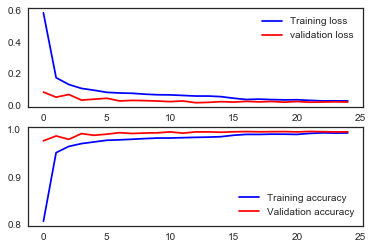

In [25]:
# Plot the loss and accuracy curves for training and validation vs. epochs
# Since I have just 1 epoch, the curves are empty
#fig, ax = plt.subplots(2,1)
#ax[0].plot(history.history['loss'], color='b', label="Training loss")
#ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
#legend = ax[0].legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

Confusion matrix helps us to understand model error or misclassification.  
I don't see any direct way to get the confusion matrix from Keras and therefore, the following function is used.

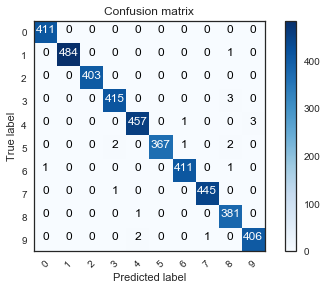

In [26]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few misclassification errors.  
It seems that our CNN has some little troubles with the 9, 8 and so on digits, they are misclassified as 4, 7, 1 etc. For example, sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth and so on.  

### Error analysis

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

Errors are difference between predicted labels and true labels

In [27]:
errors = (Y_pred_classes - Y_true != 0)

Next we define the following function to display some errors:

In [28]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


Then define and evaluate the following quantities:

In [29]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

Show the top 6 errors

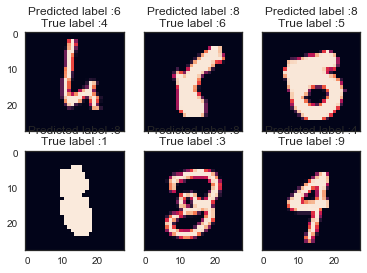

In [30]:
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

We see that these errors are also can easily be made by humans. These digits are written almost imcomplete.

# 5. Submission

Following is the submission on the test datatset:

In [31]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [32]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

# Model comparison (Additional)

These models are based on Gradient Descent (GD) approach and estimation of loss with backpropagation (some details in references). 

## 1. SGD: Stochastic Gradient descent

In SGD, we update the weights based on each training example, not the batch as a whole as done in GD.   
That is, weights are updated elementwise as wj:=wj+dwj instead of as a whole as W:=W+dW.  
SGD is computationally less demanding than GD since we don't have to run through the whole training set to update the weights.  
Although SGD minimizes loss faster, it is noisier and it oscillates around the the minimum giving some variation in accuracy and loss run to  run.  

In Keras implementation of SGD, I am using LR of 0.01. Keras gives option to use momentum and decay of LR in SGD but I am not using those (set to 0). Momentum enables faster gradient descent.  
"nesterov" gives option to use mementum in a different way. It is set to False. Use of momentum helps to to achive faster convergence of gradient descent.

In [20]:
sgd = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
modelsgd = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 387s - loss: 2.2419 - acc: 0.1742 - val_loss: 1.6659 - val_acc: 0.6410


In [21]:
#print(modelsgd.history.keys())
sgdacc= modelsgd.history['val_acc']

## 2. RMSProp

RMSProp is root mean squared propagation. In this algorithm, we divide the learning rate for a weight by a running average of	the magnitudes	of	recent	gradients for that weight. This helps in faster gradient descent and it is more accurate than SGD. 
RMSProp was proposed by Geoffrey Hinton.

In Keras implementation of RMSProp, I am using LR of 0.01 and rest of the values as default as recommended.  

In [22]:
rmsprop = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
modelrmsprop = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 377s - loss: 0.3414 - acc: 0.8957 - val_loss: 0.0857 - val_acc: 0.9726


In [23]:
rmspropacc = modelrmsprop.history['val_acc']

Note that we already have much better accuracy with RMSProp compared to SGD.

## 3. Adagrad

In Adagrad method, we have adaptive learning rate i.e. learning rate is adjusted based on the learning in previous step. We have different learning rate for different parameters at every step of the neural net. Because of learning rate is updated with 1/sqrt(grad^2+epsilon) in Adagrad, high gradient learning rate gets reduced and small gradient lerrning rate is increased.  Adagrad helps in learning from sparse (less frequent) data.  

In Keras implementation of Adagrad, I am using learning rate of 0.01 to start with without any decay (decay=0) for learning rate.  

In [24]:
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
modeladagrad = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 388s - loss: 0.2708 - acc: 0.9578 - val_loss: 0.0512 - val_acc: 0.9845


In [25]:
adagradacc = modeladagrad.history['val_acc']

## 4. Adadelta

Adadelta is an extension of Adagrad. Adadelta addresses the monotonically decreasing LR in Adagrad (accumulated thourgh squared gradient in learning rate update in the denominator in Adagrad). It scales the learning rate within certain window (with the rho parameter) together with having a momentum (faster convergence) approach.

Default LR is not quite important in Adadelta. In Keras implementation, I have kept it as 1.

In [26]:
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
modeladadelta = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 378s - loss: 0.0748 - acc: 0.9786 - val_loss: 0.0464 - val_acc: 0.9876


In [27]:
adadeltaacc = modeladadelta.history['val_acc']

## 5. Adam

Adam (Adaptive Moment Estimation) is basically RMSProp with momentum. In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. An alternative to Adam can be SGD+Nesterov Momentum. Adam starts with zero bias. More details about Adam with bias correction and can be found in the references at the end. 

Adam update rules with bias correction are as follow. Here dx is the gradient, beta1 and beta2 are the parameters introduced in the algorithms (they are close to 1), m is smooth version of gradient, v is the defined momentum and t as number of iterations:

m = beta1 x m + (1-beta1) x dx  
mt = m / (1-beta1^t)  
v = beta2 x v + (1-beta2) x (dx^2)  
vt = v / (1-beta2^t)    
x += - learning_rate x mt / (np.sqrt(vt) + eps)  

In Keras implementation of Adam, I am using LR of 0.01 and other values at default as recommended. 

In [28]:
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modeladam = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 432s - loss: 0.0694 - acc: 0.9804 - val_loss: 0.0476 - val_acc: 0.9860


In [29]:
adamacc = modeladam.history['val_acc']

## 6. Adamax

Adamax is generalized version of Adam. In Adam we have l1 and l2 norms in momnetum updates. In Adamax, it is extended to infinite norm (i.e. max). it provides stable convergence of gradient descent.   

Adamax parameters are similar to Adam in Keras implementation. 

In [30]:
adamax = optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
modeladamax = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 386s - loss: 0.0459 - acc: 0.9866 - val_loss: 0.0379 - val_acc: 0.9907


In [31]:
adamaxacc = modeladamax.history['val_acc']

## 7. Nadam

As stated earlier, Adam is RMSProp with momnetum. Nadam is basically Adam with momentum specified as Nesterov momentum. Then parameter update rules change accordingly.  
Keras implementation in Nadam is similar to Adam.  

In [32]:
nadam = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
modelnadam = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 378s - loss: 0.0750 - acc: 0.9783 - val_loss: 0.0464 - val_acc: 0.9886


In [33]:
nadamacc = modelnadam.history['val_acc']

Let us look at the accuracies of these models all together.

In [43]:
accuracy = []
accuracy.append(sgdacc)
accuracy.append(rmspropacc)
accuracy.append(adagradacc)
accuracy.append(adadeltaacc)
accuracy.append(adamacc)
accuracy.append(adamaxacc)
accuracy.append(nadamacc)

Optimizers = ['SGD', 'RMSProp', 'Adagrad','Adadelta','Adam','Adamax','Nadam']

models_dataframe=pd.DataFrame(accuracy, index=Optimizers) 
models_dataframe.columns=['Accuracy']
models_dataframe
models_dataframe.sort_values(['Accuracy'], ascending=[0])

,Accuracy
Adamax,0.990714
Nadam,0.988571
Adadelta,0.987619
Adam,0.985952
Adagrad,0.984524
RMSProp,0.972619
SGD,0.640952


Adamax is showing the highest accuracy. However, I would say that except SGD, all other models are quite close. Also, these accuracies are just with one epoch.

## What optimizer to pick?

The most basic optimizers are gradient descent (GD) and then stochastic gradient descent (SGD). Later optimizers all perform better than SGD in general. In sparse data, we can use adaptive learning rate method such as Adagrad or Adadelta. Then RMSProp is an extension of Adagrad that accounts for its monotonically vanishing learning rate. Adam adds momentum to RMSProp and finally bias is corrected in Adam. In that way, Adam is found to  be the most updated and overall best choice. In general, Adadelta, RMSProp and Adam should perform very similar. 

In [17]:
# Below codes compare all the different classifiers together. But it takes a while to run.
#loss=[]
#accuracy=[]
#Optimizers = ['sgd', 'rmsprop', 'Adagrad','Adadelta','Adam','Adamax','Nadam']

#for i in Optimizers:
#    model.compile(loss='categorical_crossentropy', optimizer=i, metrics=['accuracy'])
#    model.fit(X_train, Y_train, batch_size = 86, epochs = 1)
#    score, acc = model.evaluate(X_val, Y_val)
#    loss.append(score)
#    accuracy.append(acc)
#    
#cv_models_dataframe=pd.DataFrame(accuracy, index=Optimizers) 
#cv_models_dataframe.columns=['Accuracy']
#cv_models_dataframe
#cv_models_dataframe.sort_values(['Accuracy'], ascending=[0])
#


## Reference

* I took direct help from [Yassine G.'s very popular kernel](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) on this analysis of this digit recognizer dataset (Thank you!) and some help from Keras documentation. I used slightly different network with Adam optimizer instead of RMSProp. The confusion matrix and error Analysis I learned from his kernel is really insightful and helpful to me.
* Links to material I went through to understand different Neural Network algorithms based on Gradient Descent Optimization  
  * Geoffrey Honton's [notes](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
  * Stanford CS231 [notes and discussion](http://cs231n.github.io/neural-networks-3) on the algorithms
  * [Blog](http://ruder.io/optimizing-gradient-descent/index.html) by Sebastian R.
  * A good read about [SGD](https://www.quora.com/Whats-the-difference-between-gradient-descent-and-stochastic-gradient-descent) in Quora